In [90]:
# load('packaging.rda', verbose=T)
# load('data_handling.rda', verbose=T)
# load('seurat_handling.rda', verbose=T)
load('plotting.rda', verbose=T)
load('pseudobulk_generation.rda', verbose=T)
set_parallel()

Loading objects:
  fig
  save_functions
  set_parallel
Loading objects:
  dimred.auto
  example.pseudobulk_generate
  generate.pseudobulk
  get.average.expression
  get.grouped.cells
  get.seurat.from.cells
  merge.seurat
  rename.seurat.cells
  restore.factors
  sample.recursively
  sample.simspec
  save_functions
  set_parallel
  summarise.metadata


[1] 96

In [27]:
example.pseudobulk_dea <- function(...){
    
    datalist <- example.pseudobulk_generate(return.=T, agg.method='aggregate', min_seed_num = 2, ...)
    
    return(datalist)
}

First we load the object ifnb
                  orig.ident nCount_RNA nFeature_RNA stim seurat_annotations
AAACATACATTTCC.1 IMMUNE_CTRL       3017          877 CTRL          CD14 Mono
AAACATACCAGAAA.1 IMMUNE_CTRL       2481          713 CTRL          CD14 Mono
AAACATACCTCGCT.1 IMMUNE_CTRL       3420          850 CTRL          CD14 Mono
AAACATACCTGGTA.1 IMMUNE_CTRL       3156         1109 CTRL                pDC
AAACATACGATGAA.1 IMMUNE_CTRL       1868          634 CTRL       CD4 Memory T
AAACATACGGCATT.1 IMMUNE_CTRL       1581          557 CTRL          CD14 Mono


Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


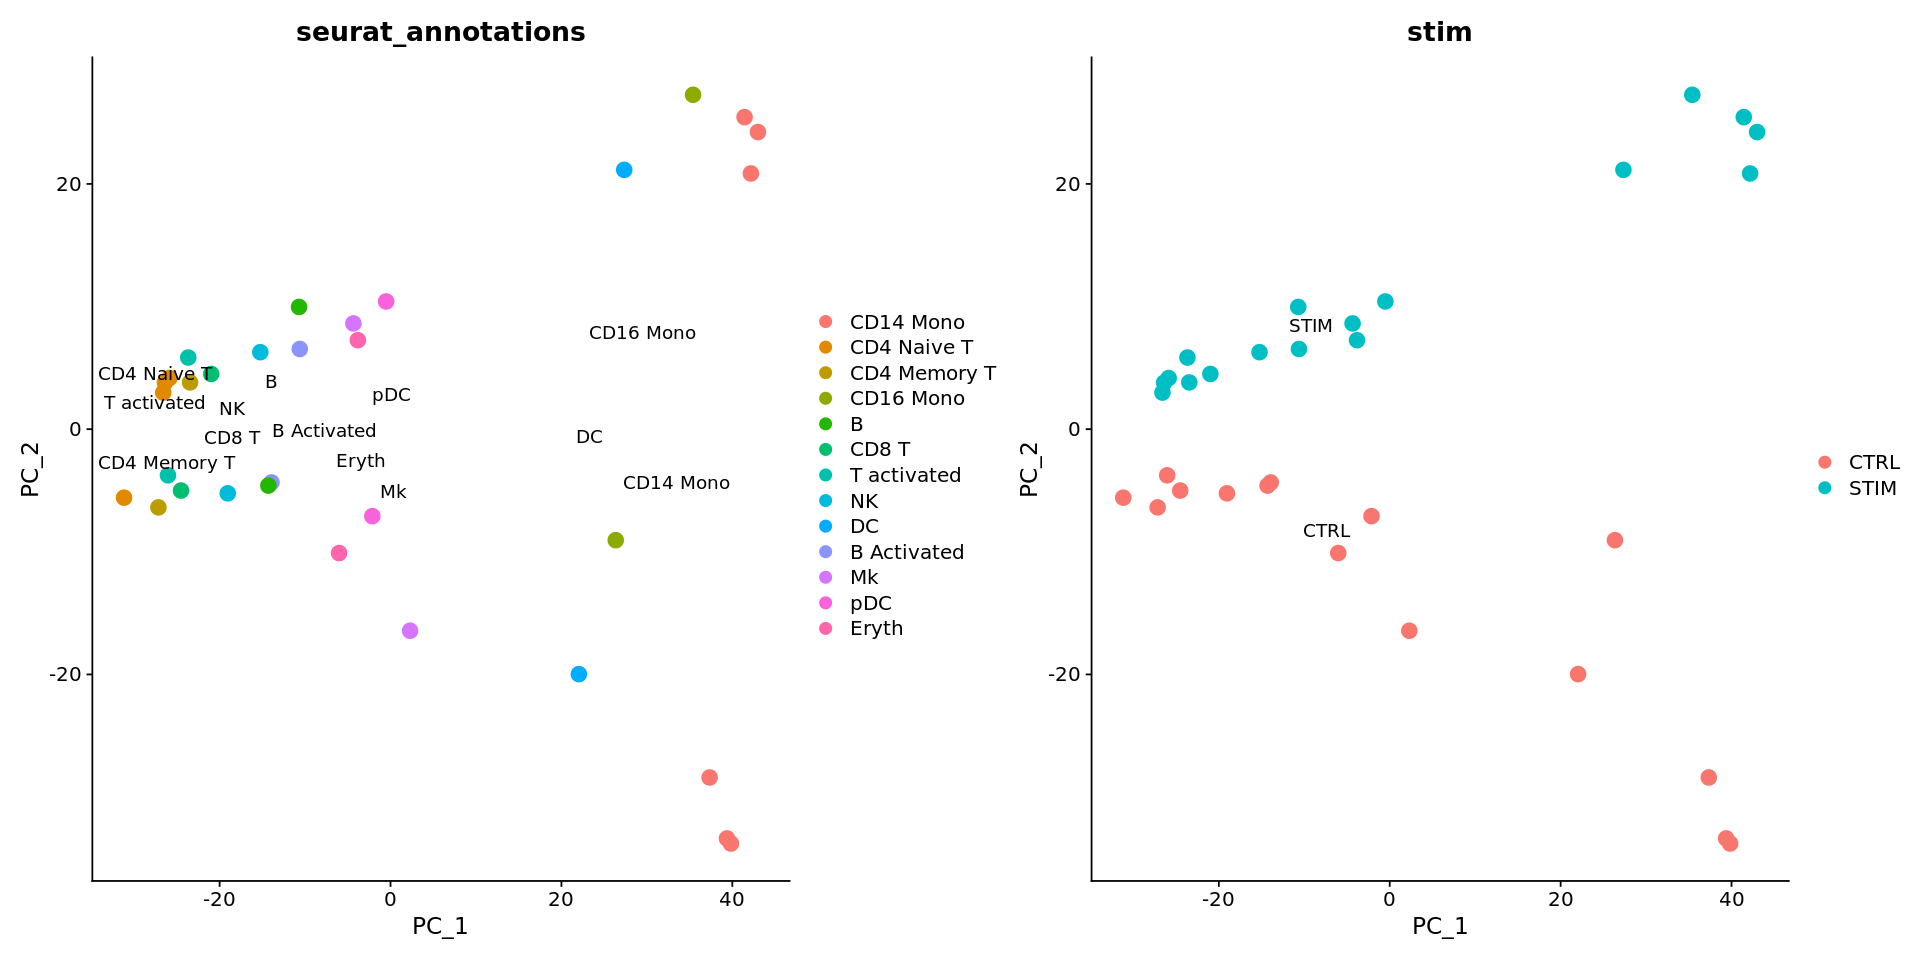

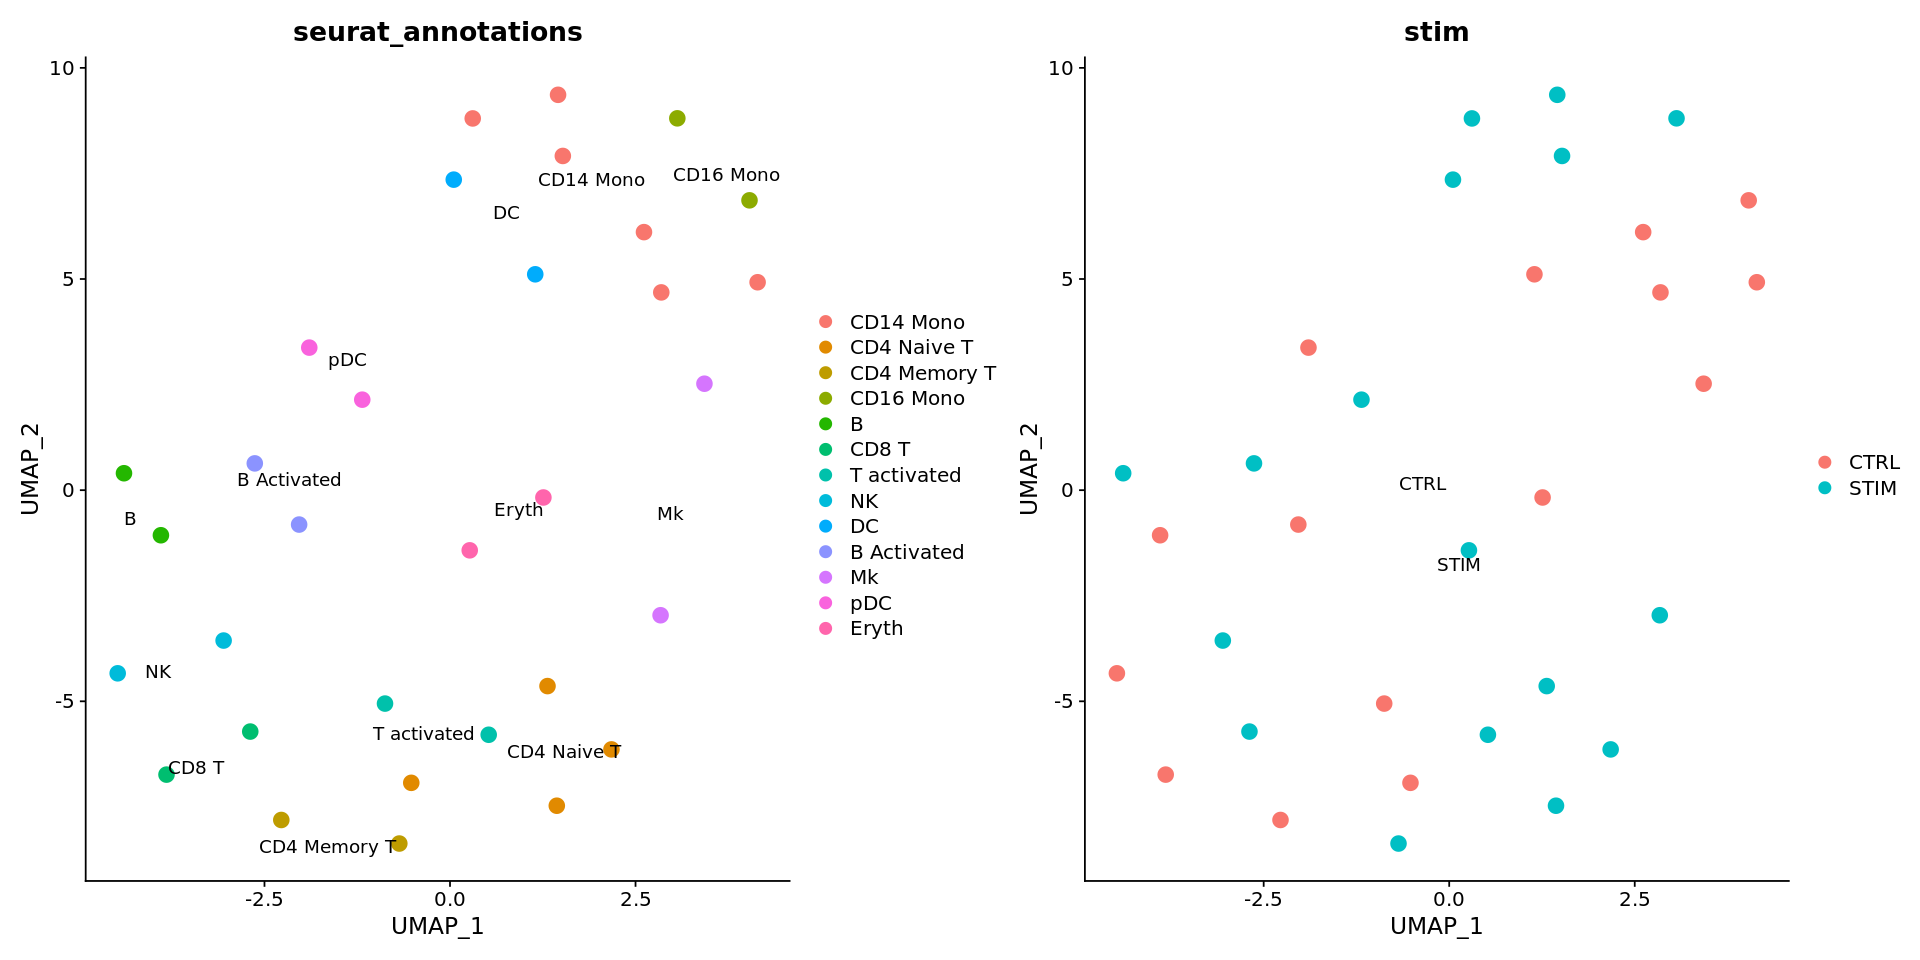

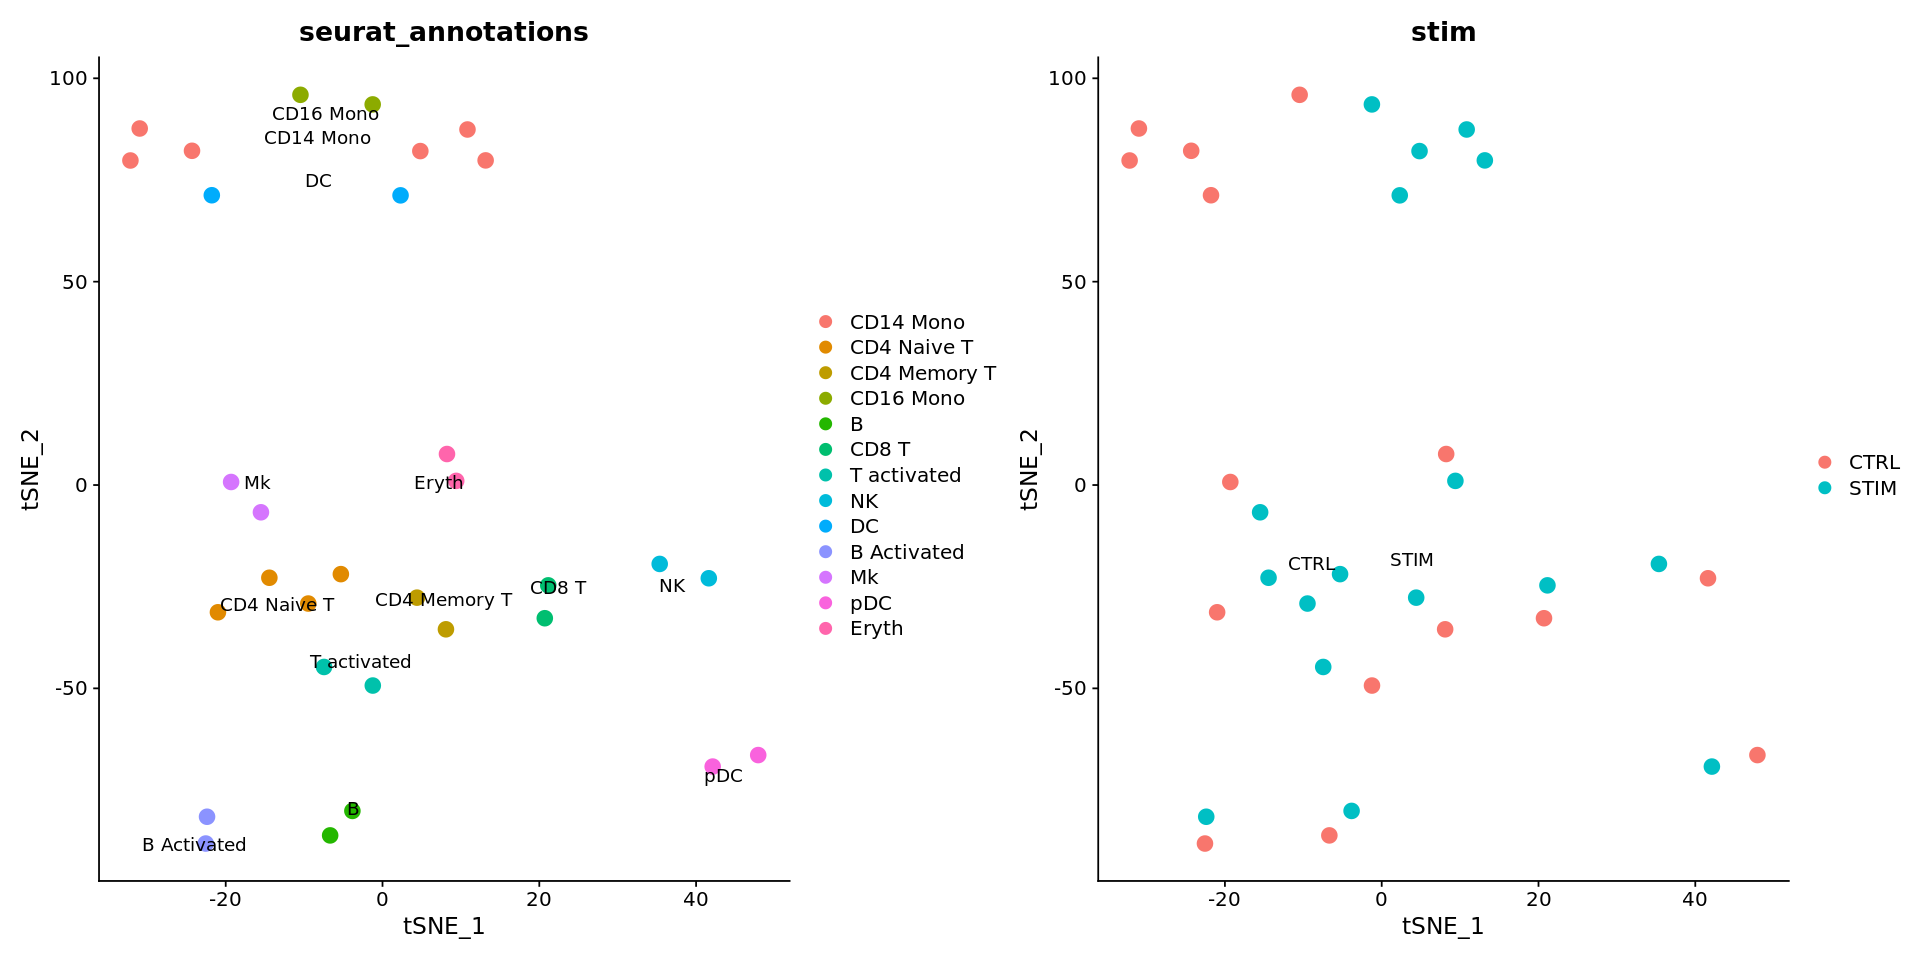

In [28]:
datalist <- example.pseudobulk_dea(verbose=F)
object <- datalist$data
psbk <- datalist$pseudobulk

#### DESeq2 functions

In [ ]:
pseudobulk.dea(
    object, 
    group.vars, cluster.var,
    test.var, covar.vars, 
    interactions,
    per.cluster,
    
)

In [29]:
library(DESeq2)

In [30]:
psbk$T_cell <- sapply(strsplit(as.character(psbk@meta.data$seurat_annotations), split=' ', fixed=T), function(x){'T'%in%x})

In [141]:
seu <- psbk

In [151]:
comp.var <- c('seurat_annotations', 'stim')

In [143]:
if (!is.factor(seu@meta.data[,comp.var])){
    seu@meta.data[,comp.var] <- factor(seu@meta.data[,comp.var])
}

In [146]:
study.design <- paste('~ stim + seurat_annotations')

In [190]:
do.formula <- function(variables=NULL, interactions=F){
    
    terms <- c()
    
    if (!is.null(variables)){
        terms <- c(terms, variables)
    }

    if (is.list(interactions)){
        for (i in 1:length(interactions)){
            terms <- c(terms, paste(interactions[[i]], collapse=':'))
        }
    } else if (interactions & (length(variables)>1)){
        for (i in 1:(length(variables)-1)){
            terms <- c(terms, paste(variables[i], variables[-c(1:i)], sep=':'))
        }
    }
    form <- paste0('~', paste(terms, collapse=' + '))
    return(formula(form))
}

In [198]:
dea.DESeq2 <- function(counts, metadata, design,
                       test = "LRT" # 'Wald'
                      ){
    
    # Create DESeq2 object        
    dds <- DESeqDataSetFromMatrix(counts%>%as.matrix, 
                                  colData = metadata, 
                                  design = design)
    
    # Transform counts for data visualization
    rld <- rlog(dds, blind=TRUE)
    
    # Run DESeq2 differential expression analysis
    dds <- DESeq(dds, test = test)   
    
    return(list(dds=dds, rld=rld))
}

In [243]:
plot.DESeq2.basics <- function(dds, rld, color.vars=NULL){
    
    require(DESeq2)
    require(pheatmap)
    
    plots <- list()
    # Plot PCA
    if (!is.null(color.vars)){
        p1 <- NULL
        for (cvar in color.vars){
            if(is.null(p1)){
                p1 <- plotPCA(rld, ntop = 500, intgroup = cvar)
            }else{
                p1 <- p1+plotPCA(rld, ntop = 500, intgroup = cvar)
            }
        }
        plots[['PCA']] <- p1
        message('PCA')
        grid::grid.draw(p1)
        grid::grid.newpage()
    }

    fig(10,7)
    # Extract the rlog matrix from the object and compute pairwise correlation values
    rld_mat <- assay(rld)
    rld_cor <- cor(rld_mat)

    # Plot heatmap
    plots[['corr']] <- if (is.null(color.vars)){pheatmap(rld_cor, silent = T)}else{pheatmap(rld_cor, silent = T, annotation = as.data.frame(colData(dds)[, color.vars, drop=F]))}
    message('Sample correlation plot')
    grid::grid.draw(plots[['corr']])
    grid::grid.newpage()
    
    # Plot dispersion estimates
    message('Dispersion estimates plot')
    plotDispEsts(dds)
    grid::grid.newpage()

    return(plots)
}

In [207]:
dds <- dea.DESeq2(seu[['RNA']]@counts%>%as.matrix, metadata = seu@meta.data, design = formula('~stim'), test = 'Wald')
rld <- dds$rld
dds <- dds$dds

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
rlog() may take a few minutes with 30 or more samples,
vst() is a much faster transformation

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 262 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



PCA

Sample correlation plot



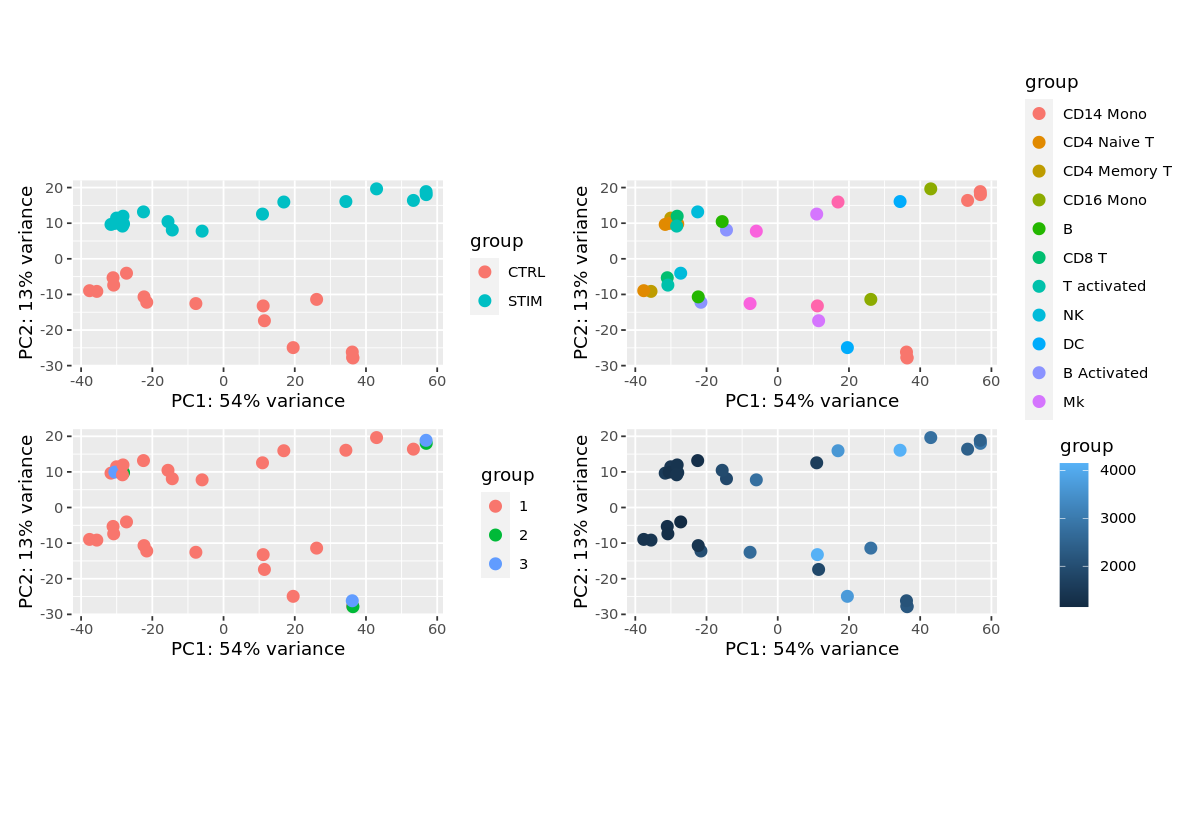

Dispersion estimates plot



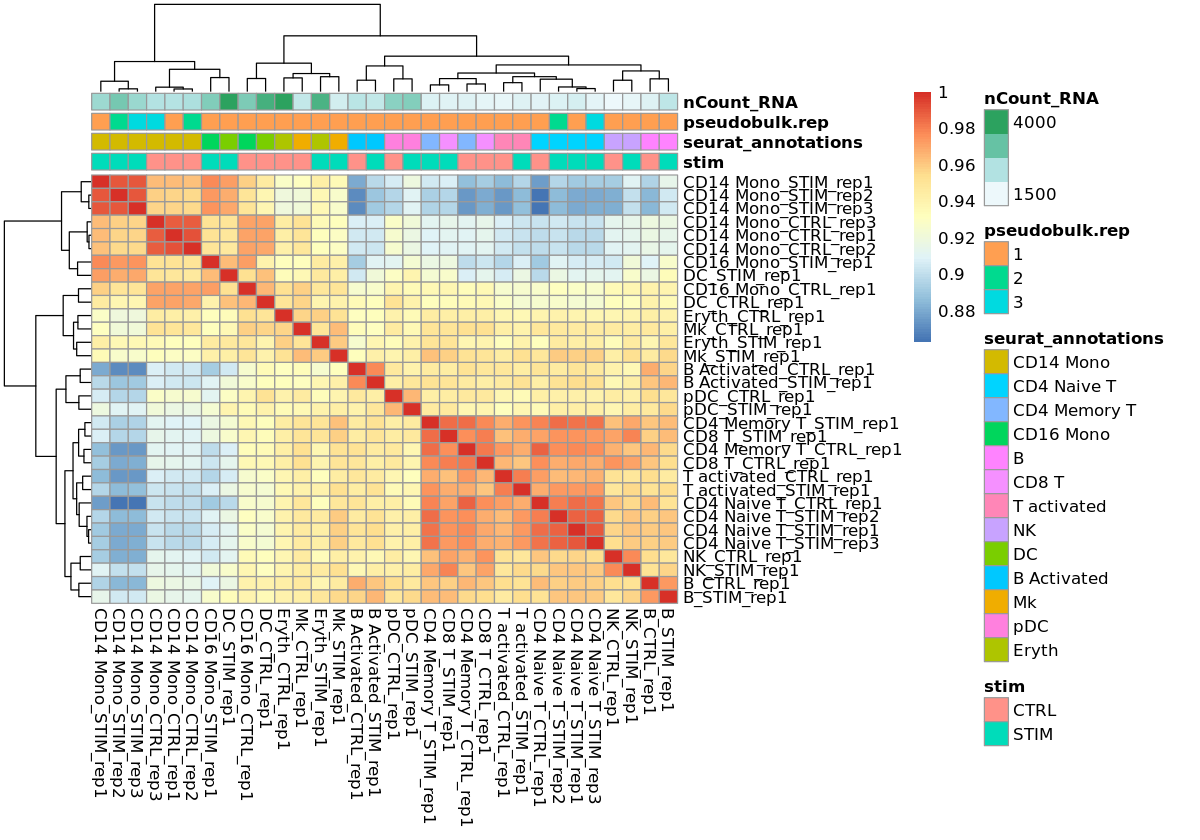

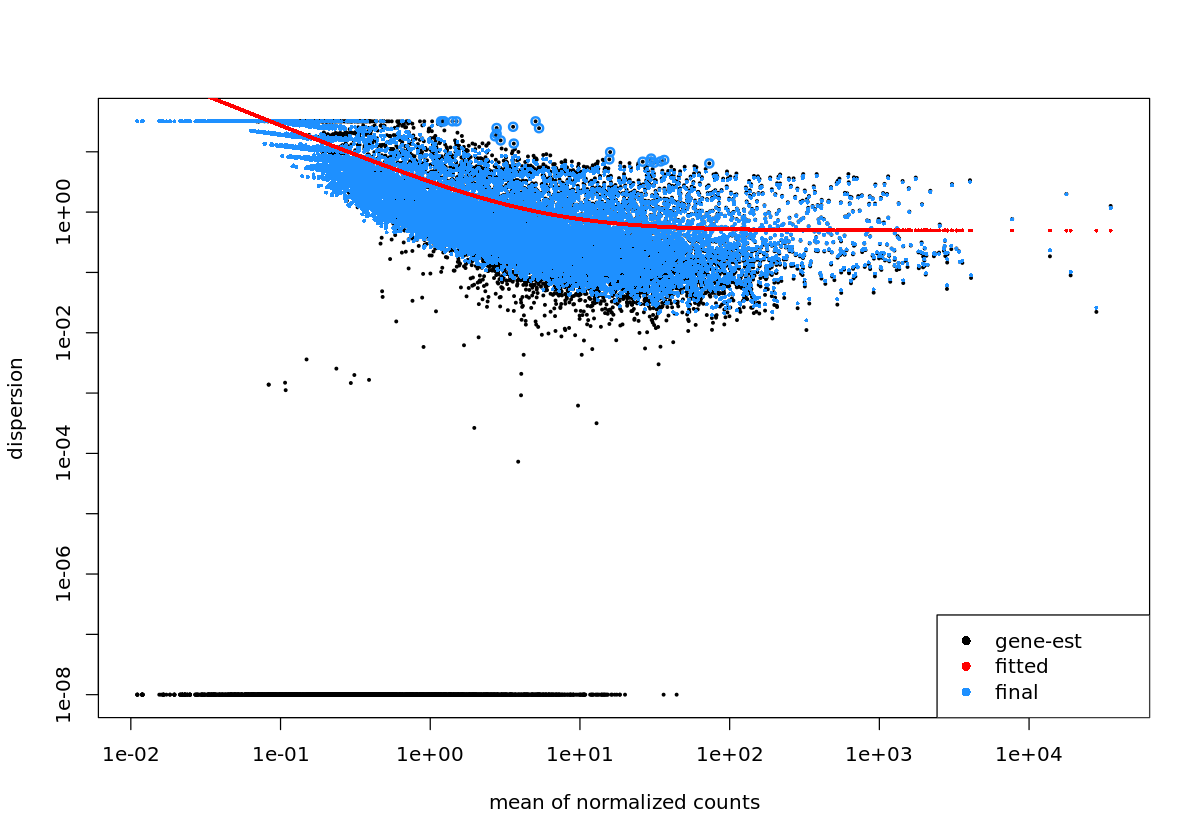

In [246]:
ps <- plot.DESeq2.basics(dds, rld, color.vars = c('stim', 'seurat_annotations', 'pseudobulk.rep', 'nCount_RNA'))

In [158]:
# Check the coefficients for the comparison
resultsNames(dds)


[1] "Intercept"                                   
 [2] "stim_STIM_vs_CTRL"                           
 [3] "seurat_annotations_CD4.Naive.T_vs_CD14.Mono" 
 [4] "seurat_annotations_CD4.Memory.T_vs_CD14.Mono"
 [5] "seurat_annotations_CD16.Mono_vs_CD14.Mono"   
 [6] "seurat_annotations_B_vs_CD14.Mono"           
 [7] "seurat_annotations_CD8.T_vs_CD14.Mono"       
 [8] "seurat_annotations_T.activated_vs_CD14.Mono" 
 [9] "seurat_annotations_NK_vs_CD14.Mono"          
[10] "seurat_annotations_DC_vs_CD14.Mono"          
[11] "seurat_annotations_B.Activated_vs_CD14.Mono" 
[12] "seurat_annotations_Mk_vs_CD14.Mono"          
[13] "seurat_annotations_pDC_vs_CD14.Mono"         
[14] "seurat_annotations_Eryth_vs_CD14.Mono"

In [159]:
# Generate results object
res <- results(dds, 
               name = "stim_STIM_vs_CTRL",
               alpha = 0.05)

# Shrink the log2 fold changes to be more appropriate using the apeglm method - should cite [paper]() when using this method
res <- lfcShrink(dds, 
                 coef = "stim_STIM_vs_CTRL",
                 res=res,
                 type = "apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [160]:
# Turn the DESeq2 results object into a tibble for use with tidyverse functions
res_tbl <- res %>%
  data.frame() %>%
  tibble::rownames_to_column(var = "gene") %>%
  as_tibble() %>%
  arrange(padj)

# Check results output
res_tbl 

# Write all results to file
# write.csv(res_tbl,
#           paste0("results/", unique(cluster_metadata$cluster_id), "_", 
#                  levels(cluster_metadata$group_id)[2], "_vs_", levels(cluster_metadata$group_id)[1], "_all_genes.csv"),
#           quote = FALSE, 
#           row.names = FALSE)


gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFI6,868.72932,5.131085,0.15974781,1.539557e-239,1.364355e-235
IRF7,478.61595,3.388779,0.10878502,3.467167e-218,1.536302e-214
EPSTI1,238.93022,3.852262,0.15145995,5.201963e-149,1.536660e-145
DRAP1,266.48488,1.722803,0.06791423,2.731177e-143,6.050922e-140
MX1,575.51354,5.119554,0.21888369,2.207513e-130,3.912596e-127
UBE2L6,388.09911,2.684217,0.11903886,6.669474e-116,9.850813e-113
TRIM22,91.78675,3.456810,0.15298791,1.381383e-115,1.748830e-112
IFI35,223.16037,3.646781,0.16859845,2.290506e-107,2.537308e-104
XRN1,75.64510,2.370589,0.11073028,4.253397e-103,4.188179e-100


In [161]:
# Set thresholds
padj_cutoff <- 0.05

# Subset the significant results
sig_res <- dplyr::filter(res_tbl, padj < padj_cutoff) %>%
  dplyr::arrange(padj)

# Check significant genes output
sig_res

# Write significant results to file
# write.csv(res_tbl,
#           paste0("results/", unique(cluster_metadata$cluster_id), "_", 
#                  levels(cluster_metadata$group_id)[2], "_vs_", levels(cluster_metadata$group_id)[1], "_signif_genes.csv"),
#           quote = FALSE, 
#           row.names = FALSE)


gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFI6,868.72932,5.131085,0.15974781,1.539557e-239,1.364355e-235
IRF7,478.61595,3.388779,0.10878502,3.467167e-218,1.536302e-214
EPSTI1,238.93022,3.852262,0.15145995,5.201963e-149,1.536660e-145
DRAP1,266.48488,1.722803,0.06791423,2.731177e-143,6.050922e-140
MX1,575.51354,5.119554,0.21888369,2.207513e-130,3.912596e-127
UBE2L6,388.09911,2.684217,0.11903886,6.669474e-116,9.850813e-113
TRIM22,91.78675,3.456810,0.15298791,1.381383e-115,1.748830e-112
IFI35,223.16037,3.646781,0.16859845,2.290506e-107,2.537308e-104
XRN1,75.64510,2.370589,0.11073028,4.253397e-103,4.188179e-100


In [162]:
# Set thresholds
log2fc_cutoff <- 0.58

# Count significantly up/down genes above threshold
n_sig_up <- dplyr::filter(sig_res, log2FoldChange >= log2fc_cutoff) %>% 
  nrow()
n_sig_dn <- dplyr::filter(sig_res, log2FoldChange <= -log2fc_cutoff) %>% 
  nrow()


In [163]:
# Scatterplot
require(reshape2)
require(data.table)
## Extract normalized counts from dds object
normalized_counts <- counts(dds, normalized = TRUE)

## Extract top 20 DEG from resLFC (make sure to order by padj)
top20_sig_genes <- sig_res %>%
  dplyr::arrange(padj) %>%
  dplyr::pull(gene) %>%
  head(n = 20)

## Extract matching normalized count values from matrix
top20_sig_counts <- normalized_counts[rownames(normalized_counts) %in% top20_sig_genes, ]
# top20_sig_counts

In [164]:
## Convert wide matrix to long data frame for ggplot2
top20_sig_df <- data.frame(top20_sig_counts)
top20_sig_df$gene <- rownames(top20_sig_counts)

top20_sig_df <- melt(setDT(top20_sig_df), 
                     id.vars = c("gene"),
                     variable.name = "pseudobulk.id") %>% 
    mutate(pseudobulk.id=plyr::mapvalues(pseudobulk.id,
                                         from=make.names(colnames(top20_sig_counts)),
                                         to=colnames(top20_sig_counts))) %>%
  data.frame()

## Join counts data frame with metadata
top20_sig_df <- plyr::join(top20_sig_df, as.data.frame(colData(dds)),
                           by = "pseudobulk.id")
# top20_sig_df

Warning message:
“Transformation introduced infinite values in continuous x-axis”


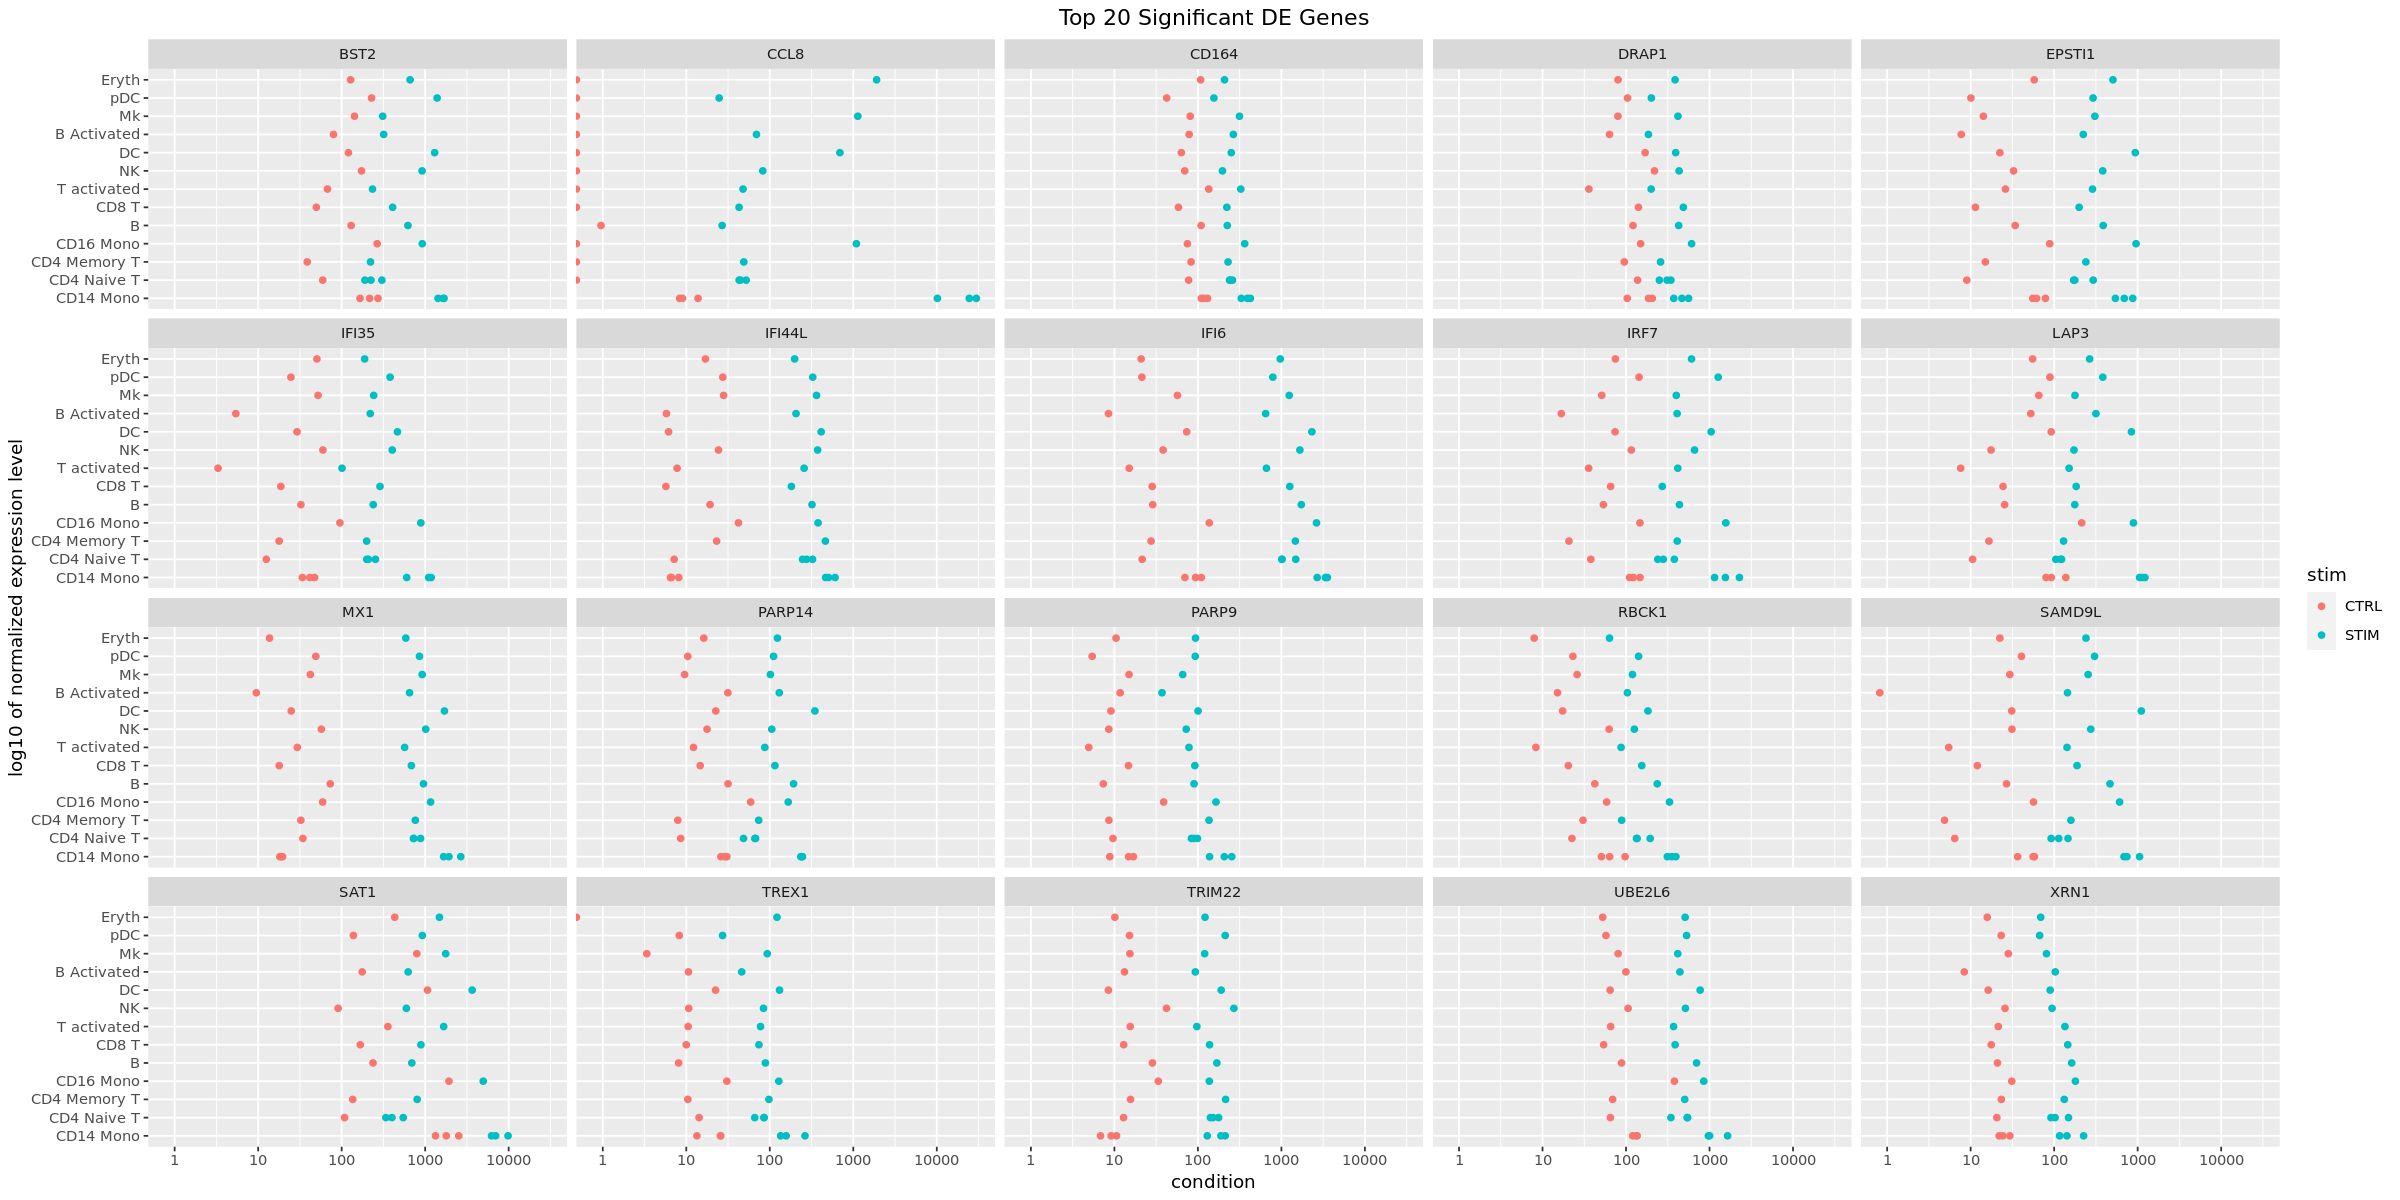

In [168]:
require(ggplot2)
fig(20,10)
## Generate plot
ggplot(top20_sig_df, aes(x = value, y = seurat_annotations, col = stim)) +
  geom_jitter(height = 0, width = 0.15) +
  scale_x_continuous(trans = 'log10') +
  ylab("log10 of normalized expression level") +
  xlab("condition") +
  ggtitle("Top 20 Significant DE Genes") +
  theme(plot.title = element_text(hjust = 0.5)) +
  facet_wrap(~ gene)

In [169]:
cluster.var <- 'stim'

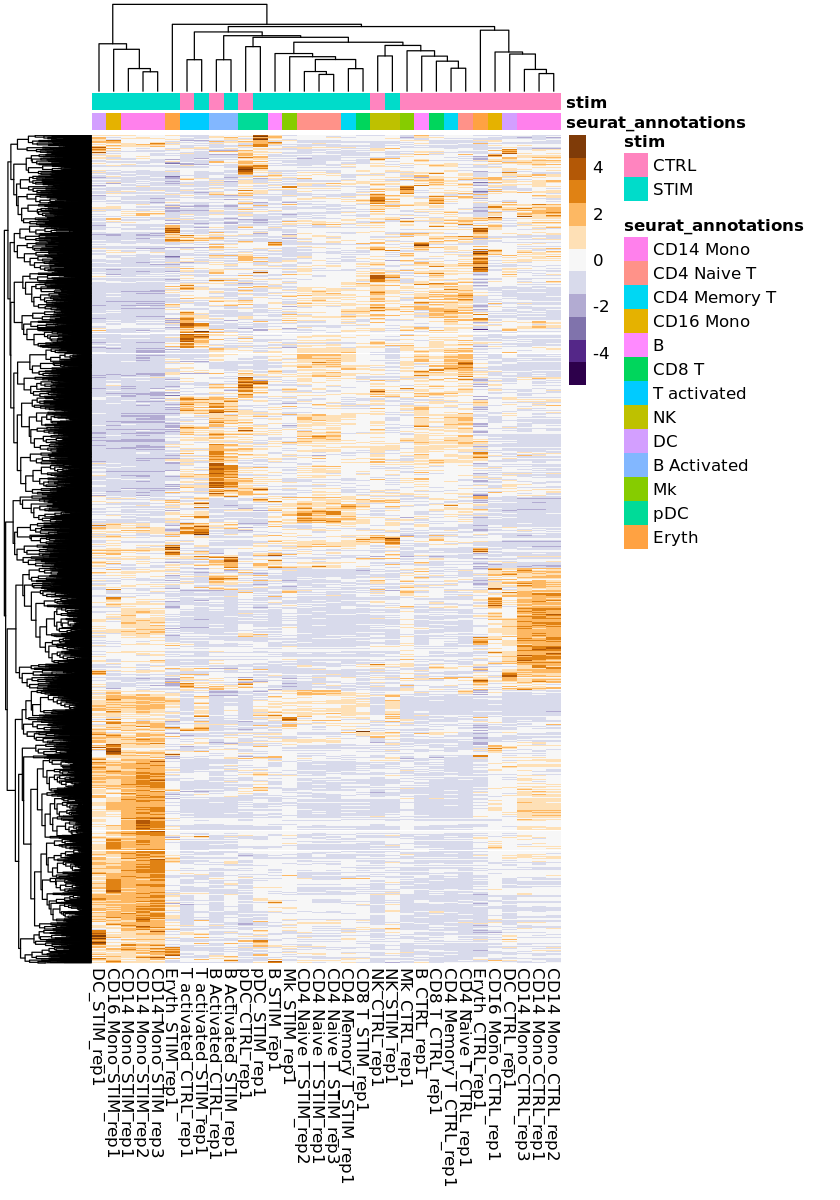

In [170]:
# Heatmap
require(RColorBrewer)

## Extract normalized counts for significant genes only
sig_counts <- normalized_counts[rownames(normalized_counts) %in% sig_res$gene, ]

## Set a color-blind friendly palette
heat_colors <- rev(brewer.pal(11, "PuOr"))

fig(7,10)
## Run pheatmap using the metadata data frame for the annotation
pheatmap(sig_counts, 
         color = heat_colors, 
         cluster_rows = TRUE, 
         show_rownames = FALSE,
         annotation = seu@meta.data[, comp.var], 
         border_color = NA, 
         fontsize = 10, 
         scale = "row", 
         fontsize_row = 10, 
         height = 20)  


[1] -234.8651

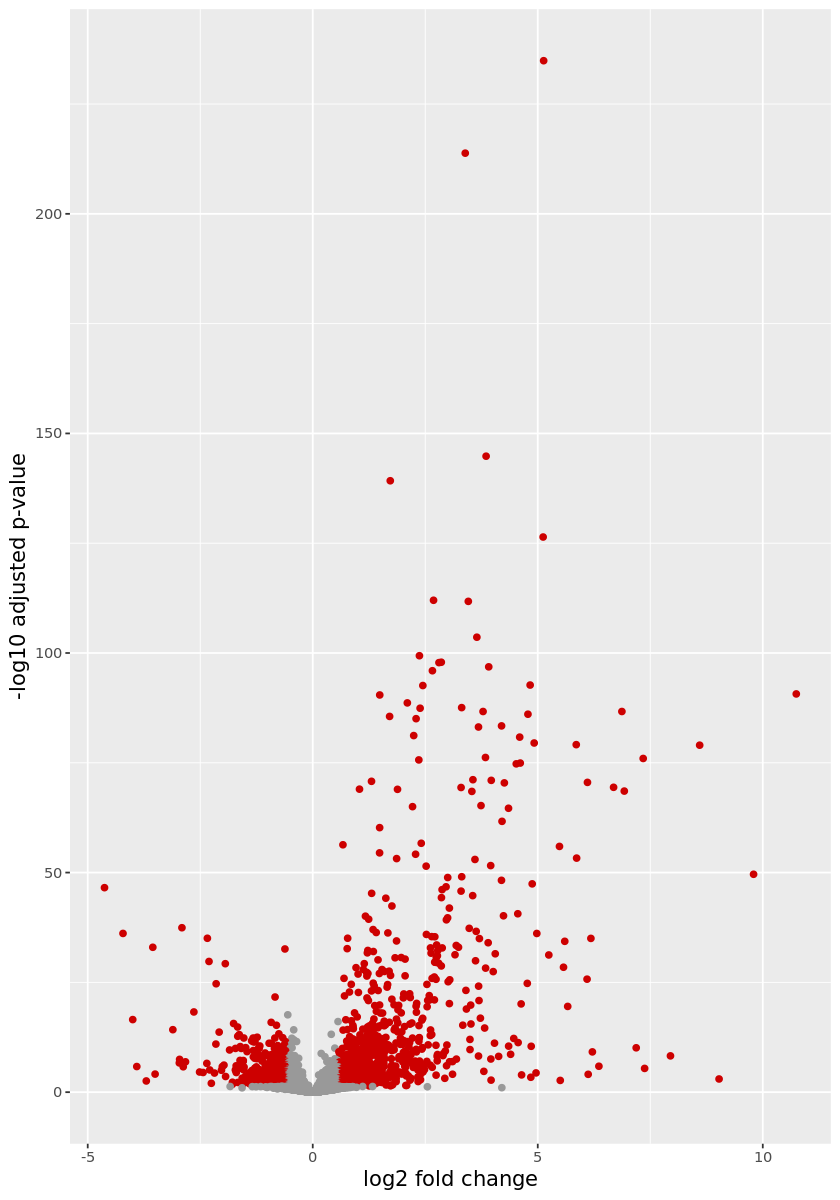

In [171]:
# Volcano plot
res_table_thres <- res_tbl[!is.na(res_tbl$padj), ] %>% 
  mutate(threshold = padj < padj_cutoff & abs(log2FoldChange) >= log2fc_cutoff)
min(log10(res_table_thres$padj))

## Generate plot
ggplot(res_table_thres) +
  geom_point(aes(x = log2FoldChange, y = -log10(padj), colour = threshold)) +
  # ggtitle("Volcano plot of stimulated B cells relative to control") +
  xlab("log2 fold change") +
  # xlim(-4.5, 12) +
  ylab("-log10 adjusted p-value") +
  # scale_y_continuous(limits = c(0, 250)) +
  scale_color_manual(values = c("grey60", "red3")) +
  theme(legend.position = "none",
        plot.title = element_text(size = rel(1.3), hjust = 0.5),
        axis.title = element_text(size = rel(1.15)))                    
